In [95]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install statsmodels
!pip3 install catboost
!pip3 install openpyxl
!pip3 install scikit-learn

In [96]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.experimental import enable_iterative_imputer  # Add this line
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from statsmodels.tsa.arima.model import ARIMA

In [97]:
# Загрузка данных
train = pd.read_excel("train.xlsx")
test = pd.read_excel("test.xlsx")

# Сортировка по дате
train = train.sort_values('dt').reset_index(drop=True)
test = test.sort_values('dt').reset_index(drop=True)

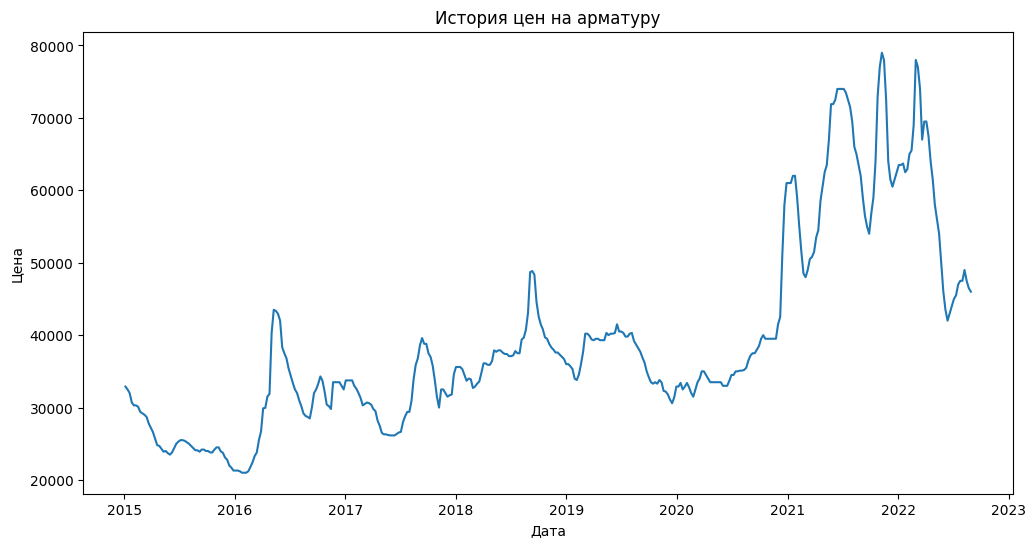

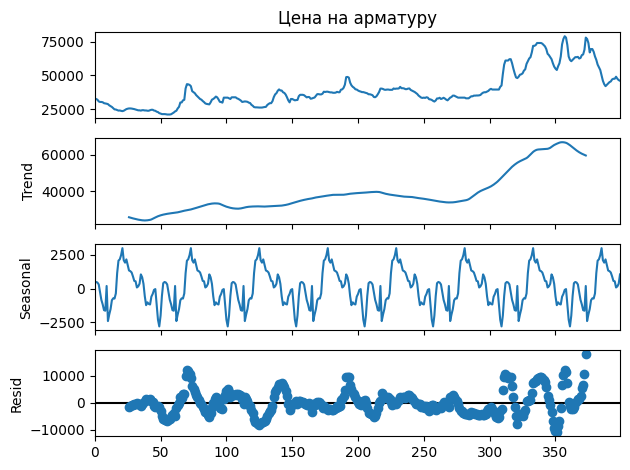

In [98]:
# График цен
plt.figure(figsize=(12, 6))
plt.plot(train['dt'], train['Цена на арматуру'])
plt.title('История цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.show()

# Декомпозиция ряда
result = seasonal_decompose(train['Цена на арматуру'], model='additive', period=52)
result.plot()
plt.show()

Генерируем признаки. Создаем лаги для того, чтобы создались цены за прошлые недели(1 - за прошлую, 2- за прошлую и т.д.). Также добавляем скользящее среднее за 8 недель и календарные признаки, которые будут давать понять о сезонности и тренде.

In [99]:
# Создание лагов
for lag in [1, 2, 3, 4]:
    train[f'lag_{lag}'] = train['Цена на арматуру'].shift(lag)

# Скользящее среднее за 8 недель
train['Скользящее среднее'] = train['Цена на арматуру'].rolling(window=8).mean()

# Календарные признаки
train['week'] = train['dt'].dt.isocalendar().week
train['month'] = train['dt'].dt.month

In [100]:
train.head()

,dt,Цена на арматуру,lag_1,lag_2,lag_3,lag_4,Скользящее среднее,week,month
0,2015-01-05,32900,NaN,NaN,NaN,NaN,NaN,2,1
1,2015-01-12,32500,32900.0,NaN,NaN,NaN,NaN,3,1
2,2015-01-19,32000,32500.0,32900.0,NaN,NaN,NaN,4,1
3,2015-01-26,30700,32000.0,32500.0,32900.0,NaN,NaN,5,1
4,2015-02-02,30300,30700.0,32000.0,32500.0,32900.0,NaN,6,2


In [101]:
test.head()

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500


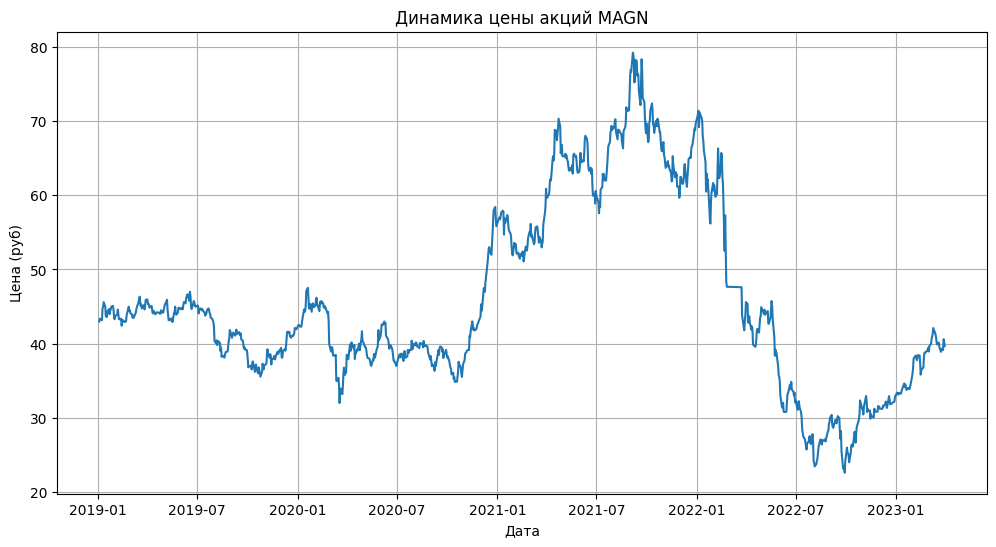

In [102]:
# Загрузка данных
df = pd.read_csv("excel_files/MAGN Акции.csv", parse_dates=["Дата"], dayfirst=True)

# График цены закрытия
plt.figure(figsize=(12, 6))
plt.plot(df["Дата"], df["Цена"].str.replace(",", ".").astype(float))
plt.title("Динамика цены акций MAGN")
plt.xlabel("Дата")
plt.ylabel("Цена (руб)")
plt.grid()
plt.show()

In [103]:
gruzoperevoski = pd.read_excel('excel_files/Грузоперевозки.xlsx')
gruzoperevoski.head()

,dt,Индекс стоимости грузоперевозок
0,2017-09-06,1000
1,2017-09-13,991
2,2017-09-20,992
3,2017-09-27,979
4,2017-10-04,985


In [104]:
data_from_market = pd.read_excel('excel_files/Данные рынка стройматериалов.xlsx')
data_from_market.head()

,dt,Импорт цемента ЖД,Экспорт цемента ЖД,Отгрузка цемента хоппер ЖД,Отгрузка цемента остальные ЖД,Производство цемента,Импорт цемента,Экспорт цемента,Потребление цемента,Отгрузка цемента,Цена цемента с НДС,Цена цемента без НДС,Производство бетона РФ,Производство бетона МО,Производство бетона СПБ
0,2021-04-30,40.751,27.530,987.540,201.757,2.3891,52.331737,31.49115,2.290941,1.189297,3769.20,4968.10,1.919781,223.405,198.589
1,2021-05-31,69.979,43.423,1071.832,256.733,2.7115,79.639340,50.16415,2.670775,1.328565,3745.23,4822.46,2.059197,293.411,162.181
2,2021-06-30,105.525,58.226,1495.351,446.953,3.8468,125.590100,64.99075,3.984199,1.942304,3790.64,5299.51,2.837929,424.112,254.893
3,2021-07-31,125.093,88.930,1754.576,573.133,4.8559,182.176201,105.96590,4.933510,2.327709,3853.30,5031.96,3.302281,492.623,301.091
4,2021-08-31,124.438,112.454,1859.549,659.929,5.7240,193.681060,141.09315,5.762688,2.519478,3915.07,5240.72,3.788132,562.724,303.961


In [105]:
index_LME = pd.read_excel('excel_files/Индекс LME.xlsx')
index_LME.columns = ["dt", "price"]
index_LME.head()

,dt,price
0,2021-02-12,607
1,2021-02-15,614
2,2021-02-16,615
3,2021-02-17,606
4,2021-02-18,604


In [106]:
Makropokozateli = pd.read_excel('excel_files/Макропоказатели.xlsx')
Makropokozateli.head()

,dt,Базовый индекс потребительских цен на товары и услуги,Ключевая ставка,Курс доллара
0,2016-01-31,NaN,NaN,NaN
1,2016-02-29,NaN,NaN,NaN
2,2016-03-31,NaN,NaN,NaN
3,2016-04-30,NaN,NaN,NaN
4,2016-05-31,NaN,NaN,NaN


In [107]:
Makropokozateli['Базовый индекс потребительских цен на товары и услуги'] = Makropokozateli['Базовый индекс потребительских цен на товары и услуги'].fillna(0)

mean_value = Makropokozateli['Ключевая ставка'].mean()
Makropokozateli['Ключевая ставка'] = Makropokozateli['Ключевая ставка'].fillna(mean_value)

mean_value1 = Makropokozateli['Курс доллара'].mean()
Makropokozateli['Курс доллара'] = Makropokozateli['Курс доллара'].fillna(mean_value1)


In [108]:
pokawateli_rinka_metall = pd.read_excel('excel_files/Показатели рынка металла.xlsx')
pokawateli_rinka_metall.head()

,dt,Производство арматуры Сортовой прокат_Арматура,Производство арматуры Сортовой прокат_Катанка,Производство арматуры Сортовой прокат_Прутки прочие,Производство сырья ЖРС_Агломерат,Производство сырья ЖРС_Аглоруда,Производство сырья ЖРС_Концентрат,Производство сырья ЖРС_Концентрат для дообогащения,Производство сырья ЖРС_Окатыши,Производство сырья Кокс_Кокс валовый,...,Экспорт сырья Лом_Лом стальной,Экспорт сырья Лом_Лом чугуна,Экспорт сырья Металлизованная продукция_Всего отгружено с предприятия,Экспорт сырья Металлизованная продукция_ГБЖ,Экспорт сырья Чугун_Всего отгружено с предприятия,Экспорт сырья Чугун_Литейный чугун,Экспорт сырья Чугун_Передельный чугун,Экспорт арматуры Сортовой прокат_Арматура,Экспорт арматуры Сортовой прокат_Катанка,Экспорт арматуры Сортовой прокат_Прутки прочие
0,2016-03-31,527,208,191,5127,376,9063,631,3691,2307,...,0,0,0,0,0,0,0,97,68,50
1,2016-04-30,563,231,216,4776,343,8850,608,3450,2297,...,0,0,0,0,0,0,0,118,79,55
2,2016-05-31,614,263,235,5107,420,9013,626,3849,2481,...,0,0,0,0,0,0,0,123,100,71
3,2016-06-30,659,242,237,4809,400,9275,613,3688,2372,...,0,0,0,0,0,0,0,129,78,61
4,2016-07-31,703,249,238,5147,420,9587,518,4032,2255,...,0,0,0,0,0,0,0,142,90,48


In [109]:
toplivo = pd.read_excel('excel_files/Топливо.xlsx')
toplivo.head()

,dt,Цена на бензин,Цена на дт
0,2017-02-28,35.91,36.15
1,2017-03-31,36.11,36.58
2,2017-04-30,36.41,36.69
3,2017-05-31,36.64,36.80
4,2017-06-30,36.91,36.87


In [110]:
price_for_raw = pd.read_excel('excel_files/Цены на сырье.xlsx')
price_for_raw.head()

,dt,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
0,2015-02-09,3850,228,12344,10009,12728,62,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-16,3850,206,12271,10432,12852,63,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-02-23,3850,207,12645,11981,13034,64,NaN,3700.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-02,3850,214,12696,11912,12910,63,NaN,3700.0,72.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN
4,2015-03-09,4400,232,12916,12061,12964,61,NaN,4050.0,70.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN


In [111]:
CHMF_Akcii = pd.read_csv('excel_files/CHMF Акции.csv')
CHMF_Akcii.columns = ['dt', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
CHMF_Akcii.head()

,dt,Price,Open,High,Low,Vol.,Change %
0,03/31/2023,"1,043.20","1,061.00","1,061.00","1,042.00",571.72K,-1.68%
1,03/30/2023,"1,061.00","1,074.60","1,084.80","1,058.00",1.30M,-1.27%
2,03/29/2023,"1,074.60","1,040.60","1,078.40","1,035.40",1.79M,3.53%
3,03/28/2023,"1,038.00","1,041.40","1,044.00","1,033.00",269.09K,-0.17%
4,03/27/2023,"1,039.80","1,036.20","1,042.60","1,032.20",410.74K,0.50%


In [112]:
MAGN_Akcii = pd.read_csv('excel_files/MAGN Акции.csv')
MAGN_Akcii.columns = ['dt', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
MAGN_Akcii.head()

,dt,Price,Open,High,Low,Vol.,Change %
0,31.03.2023,"39,69","40,21","40,24","39,52","18,23M","-1,38%"
1,30.03.2023,"40,24","40,60","41,00","40,02","27,14M","-0,87%"
2,29.03.2023,"40,60","39,15","40,65","38,96","48,70M","3,70%"
3,28.03.2023,"39,15","39,45","39,75","38,91","17,02M","-0,62%"
4,27.03.2023,"39,40","38,99","39,48","38,92","20,95M","1,26%"


In [113]:
NLMK_Akcii = pd.read_csv('excel_files/NLMK Акции.csv')
NLMK_Akcii.columns = ['dt', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']
NLMK_Akcii.head()

,dt,Price,Open,High,Low,Vol.,Change %
0,03/31/2023,129.32,130.60,130.60,128.36,3.54M,-0.98%
1,03/30/2023,130.60,132.30,133.44,129.80,4.85M,-0.94%
2,03/29/2023,131.84,128.00,134.44,127.10,10.37M,3.37%
3,03/28/2023,127.54,128.58,128.94,126.56,2.27M,-0.50%
4,03/27/2023,128.18,127.00,128.42,126.86,2.81M,1.33%


In [114]:
# Convert 'dt' columns to datetime format for all DataFrames
gruzoperevoski['dt'] = pd.to_datetime(gruzoperevoski['dt'], dayfirst=True)
train['dt'] = pd.to_datetime(train['dt'], dayfirst=True)
data_from_market['dt'] = pd.to_datetime(data_from_market['dt'], dayfirst=True)
index_LME['dt'] = pd.to_datetime(index_LME['dt'], dayfirst=True)
Makropokozateli['dt'] = pd.to_datetime(Makropokozateli['dt'], dayfirst=True)
pokawateli_rinka_metall['dt'] = pd.to_datetime(pokawateli_rinka_metall['dt'], dayfirst=True)
toplivo['dt'] = pd.to_datetime(toplivo['dt'], dayfirst=True)
price_for_raw['dt'] = pd.to_datetime(price_for_raw['dt'], dayfirst=True)
CHMF_Akcii['dt'] = pd.to_datetime(CHMF_Akcii['dt'], dayfirst=True)
MAGN_Akcii['dt'] = pd.to_datetime(MAGN_Akcii['dt'], dayfirst=True)
NLMK_Akcii['dt'] = pd.to_datetime(NLMK_Akcii['dt'], dayfirst=True)

# Merge all datasets with the training dataset on the 'dt' column
train = train.merge(gruzoperevoski, on='dt', how='left')
train = train.merge(data_from_market, on='dt', how='left')
train = train.merge(index_LME, on='dt', how='left')
train = train.merge(Makropokozateli, on='dt', how='left')
train = train.merge(pokawateli_rinka_metall, on='dt', how='left')
train = train.merge(toplivo, on='dt', how='left')
train = train.merge(price_for_raw, on='dt', how='left')
train = train.merge(CHMF_Akcii, on='dt', how='left')
train = train.merge(MAGN_Akcii, on='dt', how='left')
train = train.merge(NLMK_Akcii, on='dt', how='left')


C:\Users\Darin_btw\AppData\Local\Temp\ipykernel_4176\2490968149.py:10: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  CHMF_Akcii['dt'] = pd.to_datetime(CHMF_Akcii['dt'], dayfirst=True)
C:\Users\Darin_btw\AppData\Local\Temp\ipykernel_4176\2490968149.py:12: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  NLMK_Akcii['dt'] = pd.to_datetime(NLMK_Akcii['dt'], dayfirst=True)


In [115]:
output_file_train = 'train_output.xlsx'
train.to_excel(output_file_train, index=False)

In [116]:
train.head()

,dt,Цена на арматуру,lag_1,lag_2,lag_3,lag_4,Скользящее среднее,week,month,Индекс стоимости грузоперевозок,...,High_y,Low_y,Vol._y,Change %_y,Price,Open,High,Low,Vol.,Change %
0,2015-01-05,32900,NaN,NaN,NaN,NaN,NaN,2,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-12,32500,32900.0,NaN,NaN,NaN,NaN,3,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-01-19,32000,32500.0,32900.0,NaN,NaN,NaN,4,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-01-26,30700,32000.0,32500.0,32900.0,NaN,NaN,5,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2015-02-02,30300,30700.0,32000.0,32500.0,32900.0,NaN,6,2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
train.dtypes

dt                  datetime64[ns]
Цена на арматуру             int64
lag_1                      float64
lag_2                      float64
lag_3                      float64
                         ...      
Open                       float64
High                       float64
Low                        float64
Vol.                        object
Change %                    object
Length: 186, dtype: object

In [118]:
# Загрузка данных
data = pd.read_excel("train_output.xlsx")

# 1. Удаление столбцов с >70% пропусков
threshold = 0.7
data = data.loc[:, data.isnull().mean() < threshold]

# 2. Разделение данных по типам
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns
date_col = 'dt'

# 3. Работа с временным индексом
data = data.set_index(date_col).sort_index()

# 4. Заполнение числовых данных
data[numeric_cols] = data[numeric_cols].interpolate(method='time').ffill().bfill()

# 5. Исправление ошибки для категориальных данных
if not categorical_cols.empty:
    for col in categorical_cols:
        # Проверка, есть ли в колонке строковые значения
        if data[col].apply(lambda x: isinstance(x, str)).any():
            # Заполнение последним известным значением (ffill)
            data[col] = data[col].fillna(method='ffill').fillna(data[col].mode().iloc[0] if not data[col].mode().empty else 'Unknown')
        else:
            # Если данные не строковые, но колонка распознана как object
            data[col] = data[col].ffill()

# 6. Итеративная импутация для числовых колонок
if not numeric_cols.empty:
    imputer = IterativeImputer(random_state=0, max_iter=10)
    data[numeric_cols] = imputer.fit_transform(data[numeric_cols])

# 7. Проверка результата
print("Оставшиеся пропуски:")
print(data.isnull().sum())

# 8. Сохранение
data.reset_index().to_csv("processed_data.csv", index=False)

C:\Users\Darin_btw\AppData\Local\Temp\ipykernel_4176\814212528.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[col] = data[col].fillna(method='ffill').fillna(data[col].mode().iloc[0] if not data[col].mode().empty else 'Unknown')


Оставшиеся пропуски:
Цена на арматуру    0
lag_1               0
lag_2               0
lag_3               0
lag_4               0
                   ..
Open                0
High                0
Low                 0
Vol.                0
Change %            0
Length: 72, dtype: int64


In [119]:
# Заменить запятые в числовых колонках и преобразовать в float
for column in data.columns:
    if data[column].dtype == 'object':
        # Пробуем преобразовать, игнорируя ошибки (нечисловые значения станут NaN)
        data[column] = pd.to_numeric(data[column].astype(str).str.replace(',', ''), errors='coerce')

In [120]:
# Проверить типы данных
print(data.dtypes)

# Если есть категориальные признаки, их нужно явно указать CatBoost
categorical_features = [...]  # Список категориальных колонок

Цена на арматуру    float64
lag_1               float64
lag_2               float64
lag_3               float64
lag_4               float64
                     ...   
Open                float64
High                float64
Low                 float64
Vol.                float64
Change %            float64
Length: 72, dtype: object


In [121]:
# Посмотреть название колонки с индексом 53
column_53 = data.columns[53]
print("Название колонки:", column_53)

# Показать уникальные значения в этой колонке
print(data.iloc[:, 53].unique())

Название колонки: ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой,  $/т
[125.5 127.  116.  112.  110.  111.5 109.  115.  119.  122.  122.5 116.5
 128.5 142.5 139.5 146.5 145.5 159.5 164.5 134.5 112.5 107.5 106.  109.5
 103.5 110.5 101.  113.  117.5 120.  136.5 175.  189.  191.5 195.  222.5
 248.5 265.  268.  211.5 163.5 149.  137.  151.5 184.5 195.5 198.5 210.
 181.  178.5 159.  163. ]


In [122]:
# Заменить запятые и преобразовать в числовой формат
data.iloc[:, 53] = data.iloc[:, 53].astype(str).str.replace(',', '').astype(float)

In [123]:
# Преобразовать все колонки с типом 'object' в float (если это числовые данные)
for col in data.select_dtypes(include=['object']).columns:
    data[col] = pd.to_numeric(data[col].astype(str).str.replace(',', ''), errors='coerce')

# Заполнить пропуски (если они появились)
data = data.fillna(data.mean())

In [124]:
# Разделение данных
X = data.drop(columns=['Цена на арматуру'])
y = data['Цена на арматуру']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Указать категориальные признаки (если есть)
categorical_features = []  # Заменить на список индексов категориальных колонок

# Обучение модели
model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6)
model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    cat_features=categorical_features,
    verbose=100
)

# Сохранение модели
model.save_model('catboost_model.cbm')

0:	learn: 12506.5619681	test: 11724.5403979	best: 11724.5403979 (0)	total: 4.65ms	remaining: 4.65s
100:	learn: 923.6325550	test: 1751.6150938	best: 1751.6150938 (100)	total: 331ms	remaining: 2.94s
200:	learn: 453.1402033	test: 1437.2140255	best: 1437.0514410 (199)	total: 658ms	remaining: 2.62s
300:	learn: 267.6965568	test: 1352.0516104	best: 1352.0516104 (300)	total: 987ms	remaining: 2.29s
400:	learn: 182.6753966	test: 1329.7643364	best: 1328.7189134 (393)	total: 1.31s	remaining: 1.97s
500:	learn: 123.6013652	test: 1312.8681229	best: 1312.8681229 (500)	total: 1.65s	remaining: 1.64s
600:	learn: 85.7975677	test: 1308.0064738	best: 1307.5154791 (591)	total: 1.98s	remaining: 1.32s
700:	learn: 62.5179254	test: 1305.0149385	best: 1305.0149385 (700)	total: 2.34s	remaining: 999ms
800:	learn: 46.3841307	test: 1302.9386160	best: 1302.9371413 (797)	total: 2.67s	remaining: 662ms
900:	learn: 34.9247105	test: 1302.3967986	best: 1302.2651519 (851)	total: 2.99s	remaining: 329ms
999:	learn: 26.3572660	

In [125]:
# Загрузка исторических данных о ценах из CSV-файла
try:
    price_data = data.copy()
except FileNotFoundError:
    print("Файл не найден.")
    exit()

In [126]:
# Вывод первых нескольких строк данных
print("Первые 5 строк данных:")
print(price_data.head())

Первые 5 строк данных:
            Цена на арматуру    lag_1    lag_2    lag_3    lag_4  \
dt                                                                 
2015-01-05           32900.0  32900.0  32900.0  32900.0  32900.0   
2015-01-12           32500.0  32900.0  32900.0  32900.0  32900.0   
2015-01-19           32000.0  32500.0  32900.0  32900.0  32900.0   
2015-01-26           30700.0  32000.0  32500.0  32900.0  32900.0   
2015-02-02           30300.0  30700.0  32000.0  32500.0  32900.0   

            Скользящее среднее  week  month  \
dt                                            
2015-01-05             31025.0   2.0    1.0   
2015-01-12             31025.0   3.0    1.0   
2015-01-19             31025.0   4.0    1.0   
2015-01-26             31025.0   5.0    1.0   
2015-02-02             31025.0   6.0    2.0   

            Базовый индекс потребительских цен на товары и услуги  \
dt                                                                  
2015-01-05                      

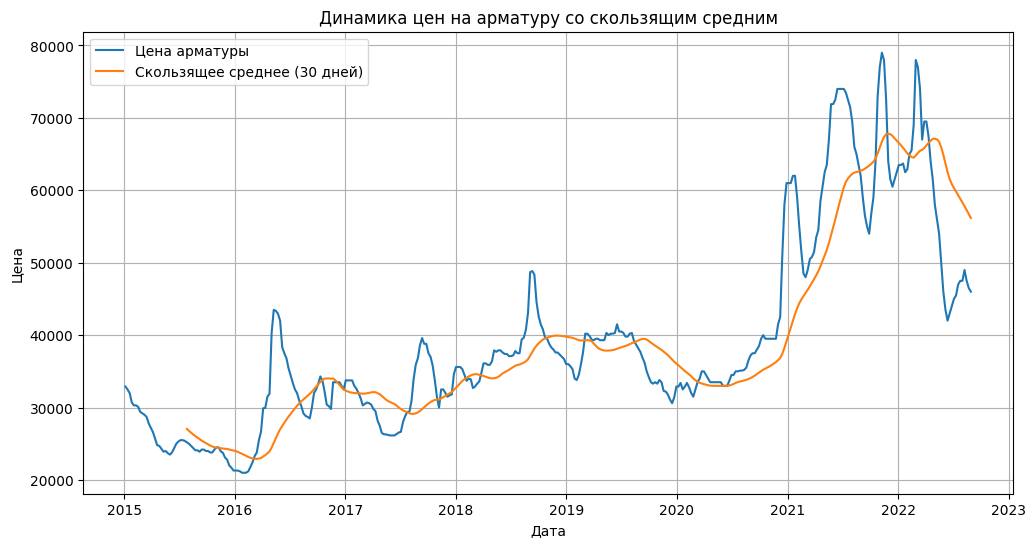

In [139]:
# Дополнительный анализ (например, скользящее среднее)
price_data['Скользящее среднее (30 дней)'] = price_data['Цена на арматуру'].rolling(window=30).mean()
plt.figure(figsize=(12, 6))
plt.plot(price_data['Цена на арматуру'], label='Цена арматуры')
plt.plot(price_data['Скользящее среднее (30 дней)'], label='Скользящее среднее (30 дней)')
plt.title('Динамика цен на арматуру со скользящим средним')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

В прогнозной линии наблюдается небольшой восходящий тренд.

c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)



Прогноз цены на следующие 10 недель:
2022-09-05    46159.095557
2022-09-12    46278.534602
2022-09-19    46590.394315
2022-09-26    47011.559303
2022-10-03    47673.317897
2022-10-10    48972.832643
2022-10-17    50757.825012
2022-10-24    52762.223271
2022-10-31    54879.554503
2022-11-07    56918.366788
Freq: W-MON, Name: predicted_mean, dtype: float64


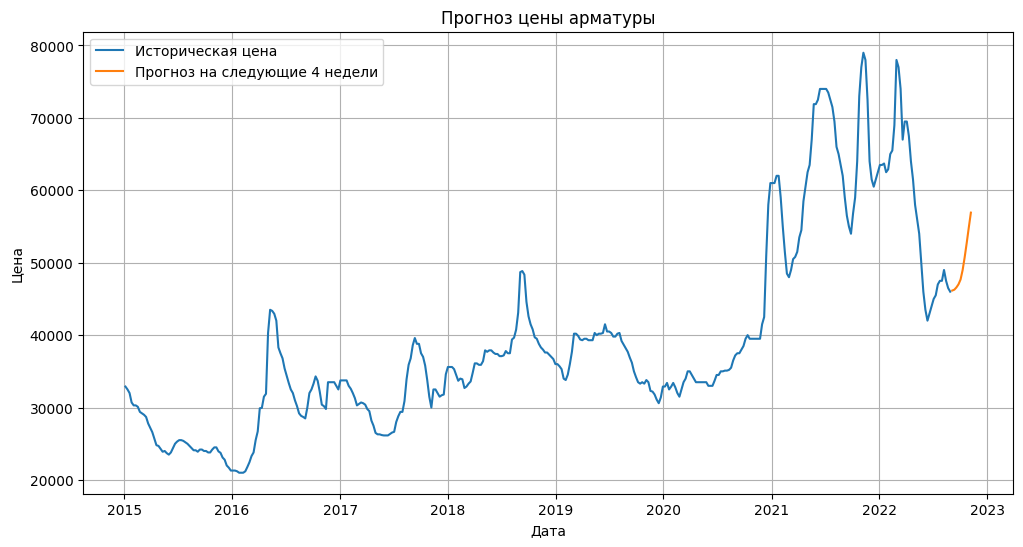

In [129]:
# Предполагаем, что у нас есть временной ряд цен 'price_data'

# Выбор порядка модели ARIMA (p, d, q) - это нужно подбирать
order = (20, 3, 0)  # Пример: AR=5, I=1 (дифференцирование), MA=0

# Обучение модели на исторических данных до недели T
# Для простоты предположим, что неделя T - это конец наших данных
model = ARIMA(price_data['Цена на арматуру'], order=order)
model_fit = model.fit()

# Прогнозирование на следующие N недель (например, N=4)
n_weeks_forecast = 10
forecast = model_fit.predict(start=len(price_data), end=len(price_data) + n_weeks_forecast - 1)

print(f"\nПрогноз цены на следующие {n_weeks_forecast} недель:")
print(forecast)

# Визуализация прогноза
plt.figure(figsize=(12, 6))
plt.plot(price_data['Цена на арматуру'], label='Историческая цена')
plt.plot(forecast, label='Прогноз на следующие 4 недели')
plt.title('Прогноз цены арматуры')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

In [130]:
print(price_data.index.dtype)
print(test.index.dtype)

datetime64[ns]
int64


In [131]:
test_df = pd.read_excel('test.xlsx', index_col='dt', parse_dates=True)

In [132]:
# ВАЖНО: Здесь используется порядок модели, который вы указали последним (20, 3, 0).
# Вы можете изменить его на более подходящий, например (1, 1, 0), если считаете, что он лучше.
order = (10, 2, 0)
model = ARIMA(price_data['Цена на арматуру'], order=order)
model_fit = model.fit()

# 3. Получение прогнозов на тестовых данных
# Определяем начальную и конечную точку для прогнозирования
start = len(price_data)
end = len(price_data) + len(test_df) - 1

# Получаем прогнозы
# dynamic=False означает, что при прогнозировании каждого шага используются фактические значения предыдущих шагов (из тестовых данных)
predictions = model_fit.predict(start=start, end=end, dynamic=False)

# Приводим индекс прогнозов к индексу тестовых данных
predictions.index = test_df.index

# 4. Оценка модели
# Рассчитываем метрики ошибки
mae = mean_absolute_error(test_df['Цена на арматуру'], predictions)
rmse = np.sqrt(mean_squared_error(test_df['Цена на арматуру'], predictions))

print(f'Средняя абсолютная ошибка (MAE): {mae:.2f}')
print(f'Корень из среднеквадратической ошибки (RMSE): {rmse:.2f}')

c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Средняя абсолютная ошибка (MAE): 3644.82
Корень из среднеквадратической ошибки (RMSE): 4291.00


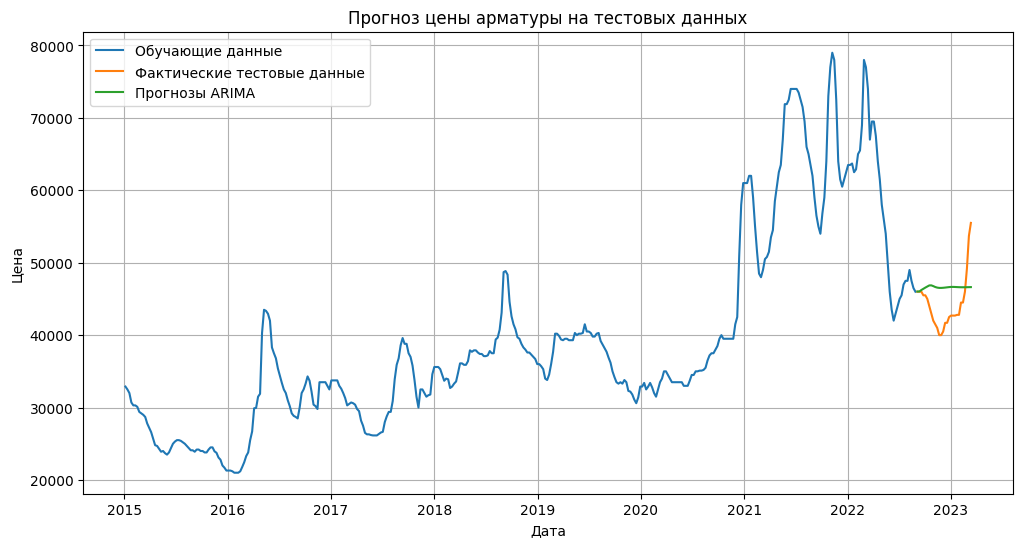

In [133]:
# 5. Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(price_data['Цена на арматуру'], label='Обучающие данные')
plt.plot(test_df['Цена на арматуру'], label='Фактические тестовые данные')
plt.plot(predictions, label='Прогнозы ARIMA')
plt.title('Прогноз цены арматуры на тестовых данных')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
print(type(test.index[0]))


<class 'int'>


In [135]:
test.index = pd.to_datetime(test.index, errors='coerce')

MAE: 647.45
RMSE: 940.65
R2-score: 0.93


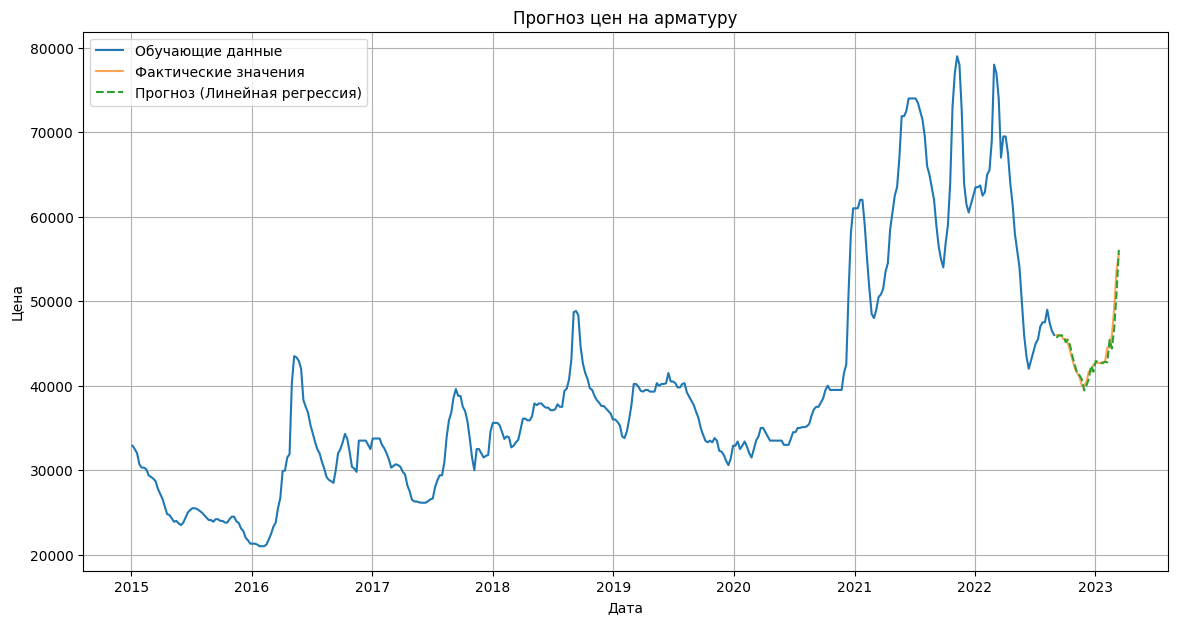

In [136]:
# 1. Загрузка данных
try:
    test_data = pd.read_excel('test.xlsx', index_col='dt', parse_dates=True)
    # Добавим явную загрузку обучающих данных
    price_data = pd.read_excel('train.xlsx', index_col='dt', parse_dates=True)
except FileNotFoundError as e:
    print(f"Ошибка: {e}")
    exit()

price_column = 'Цена на арматуру'  # Название столбца с ценами

# 2. Корректное преобразование столбцов с ценами
# Используем lambda функцию для обработки различных форматов чисел
def clean_price(price):
    if isinstance(price, (int, float)):
        return float(price)
    elif isinstance(price, str):
        # Удаляем все запятые и заменяем на точки для правильного преобразования
        return float(price.replace(',', '.').replace(' ', ''))
    return np.nan

# Применяем функцию к данным
price_data[price_column] = price_data[price_column].apply(clean_price)
test_data[price_column] = test_data[price_column].apply(clean_price)

# 3. Объединение данных для создания лагов
full_data = pd.concat([price_data, test_data], axis=0)

# 4. Создание лагированных признаков (для авторегрессии)
lags = [1, 2, 3]
for lag in lags:
    full_data[f'lag_{lag}'] = full_data[price_column].shift(lag)

# 5. Удаление строк с пропущенными значениями
full_data_clean = full_data.dropna()

# 6. Разделение на train/test по дате
test_start_date = test_data.index[0]  # Первая дата тестовых данных
X_train = full_data_clean.loc[:test_start_date].drop(price_column, axis=1)
y_train = full_data_clean.loc[:test_start_date][price_column]
X_test = full_data_clean.loc[test_start_date:].drop(price_column, axis=1)
y_test = full_data_clean.loc[test_start_date:][price_column]

# 7. Масштабирование данных
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 8. Обучение модели
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# 9. Прогнозирование
predictions = model.predict(X_test_scaled)
predictions_series = pd.Series(predictions, index=y_test.index)

# 10. Оценка модели
print(f"MAE: {mean_absolute_error(y_test, predictions):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}")
print(f"R2-score: {model.score(X_test_scaled, y_test):.2f}")

# 11. Визуализация
plt.figure(figsize=(14, 7))
plt.plot(price_data.index, price_data[price_column], label='Обучающие данные')
plt.plot(test_data.index, test_data[price_column], label='Фактические значения', alpha=0.7)
plt.plot(predictions_series.index, predictions_series, label='Прогноз (Линейная регрессия)', linestyle='--')
plt.title('Прогноз цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

MAE (Random Forest): 1269.95
RMSE (Random Forest): 1714.73
R2-score (Random Forest): 0.77


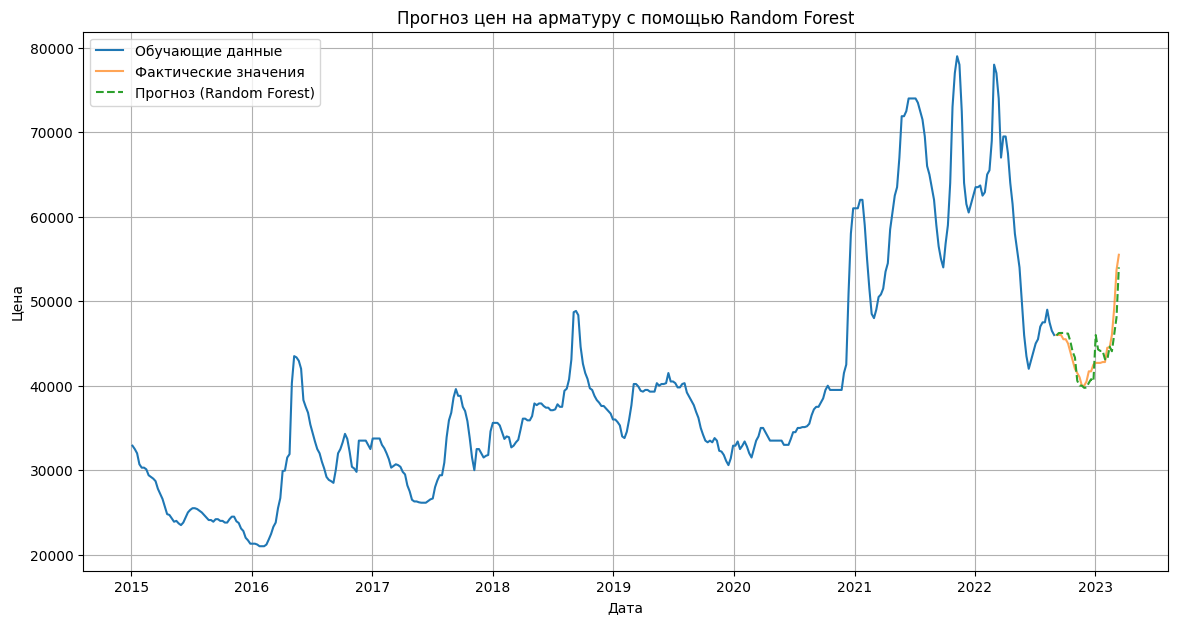

In [137]:
# Импорт необходимых библиотек
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Обучение модели Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# 2. Прогнозирование
rf_predictions = rf_model.predict(X_test_scaled)
rf_predictions_series = pd.Series(rf_predictions, index=y_test.index)

# 3. Оценка модели
mae_rf = mean_absolute_error(y_test, rf_predictions)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_predictions))
r2_rf = rf_model.score(X_test_scaled, y_test)
print(f"MAE (Random Forest): {mae_rf:.2f}")
print(f"RMSE (Random Forest): {rmse_rf:.2f}")
print(f"R2-score (Random Forest): {r2_rf:.2f}")

# 4. Визуализация
plt.figure(figsize=(14, 7))
plt.plot(price_data.index, price_data[price_column], label='Обучающие данные')
plt.plot(test_data.index, test_data[price_column], label='Фактические значения', alpha=0.7)
plt.plot(rf_predictions_series.index, rf_predictions_series, label='Прогноз (Random Forest)', linestyle='--')
plt.title('Прогноз цен на арматуру с помощью Random Forest')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Darin_btw\Documents\GitHub\intensiv_3\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: Use


Прогноз на 6 недель вперёд:
2022-09-05    45883.045918
2022-09-12    46459.704825
2022-09-19    50724.819510
2022-09-26    45591.974625
2022-10-03    43770.218527
2022-10-10    53539.564477
Freq: W-MON, dtype: float64


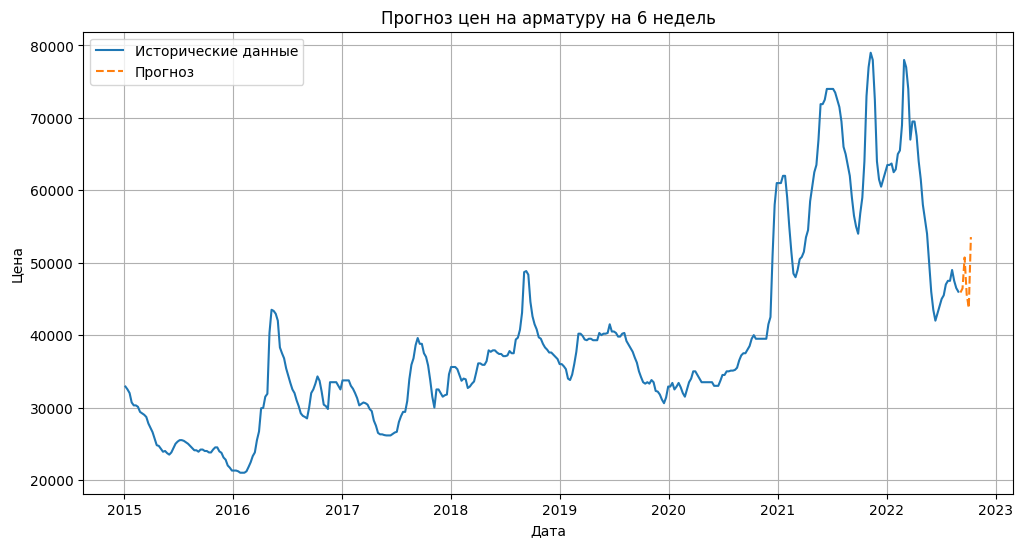

In [138]:
# Предполагаем, что данные уже загружены в price_data
# Например: price_data = pd.read_excel('train.xlsx', index_col='dt', parse_dates=True)

# 1. Подготовка данных
price_column = 'Цена на арматуру'
lags = 3  # Количество лагов (прошлых недель)

# Создание лагов
for lag in range(1, lags + 1):
    price_data[f'lag_{lag}'] = price_data[price_column].shift(lag)

# Удаление строк с пропусками
price_data_clean = price_data.dropna()

# 2. Разделение на признаки и целевую переменную
X = price_data_clean[[f'lag_{i}' for i in range(1, lags + 1)]]
y = price_data_clean[price_column]

# 3. Обучение модели линейной регрессии
model = LinearRegression()
model.fit(X, y)

# 4. Интерактивный ввод количества недель
while True:
    try:
        weeks_ahead = int(input("Введите количество недель для прогноза: "))
        if weeks_ahead <= 0:
            print("Пожалуйста, введите положительное число.")
        else:
            break
    except ValueError:
        print("Ошибка: введите целое число.")

# 5. Прогнозирование на будущее
last_known = price_data_clean.iloc[-1][[f'lag_{i}' for i in range(1, lags + 1)]].values
forecast = []

for _ in range(weeks_ahead):
    # Предсказание следующего значения
    next_pred = model.predict([last_known])[0]
    forecast.append(next_pred)
    # Обновление лагов
    last_known = np.roll(last_known, -1)
    last_known[-1] = next_pred

# 6. Создание дат для прогноза
last_date = price_data.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=weeks_ahead, freq='W-MON')

# 7. Вывод прогноза
forecast_series = pd.Series(forecast, index=forecast_dates)
print("\nПрогноз на", weeks_ahead, "недель вперёд:")
print(forecast_series)

# 8. Визуализация
plt.figure(figsize=(12, 6))
plt.plot(price_data.index, price_data[price_column], label='Исторические данные')
plt.plot(forecast_series.index, forecast_series, label='Прогноз', linestyle='--')
plt.title(f'Прогноз цен на арматуру на {weeks_ahead} недель')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.show()